/home/ematos/miniconda3/envs/fn4.pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


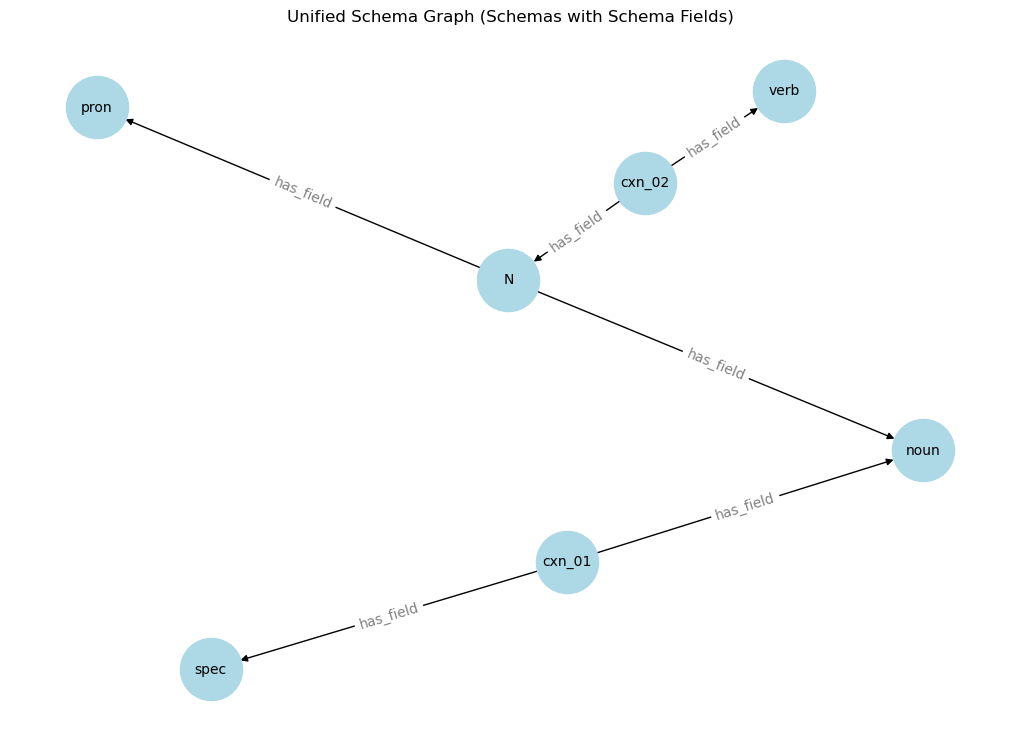

Schema node count: 7
Instance node count: 5
Instance -> Schema edges: torch.Size([2, 6])


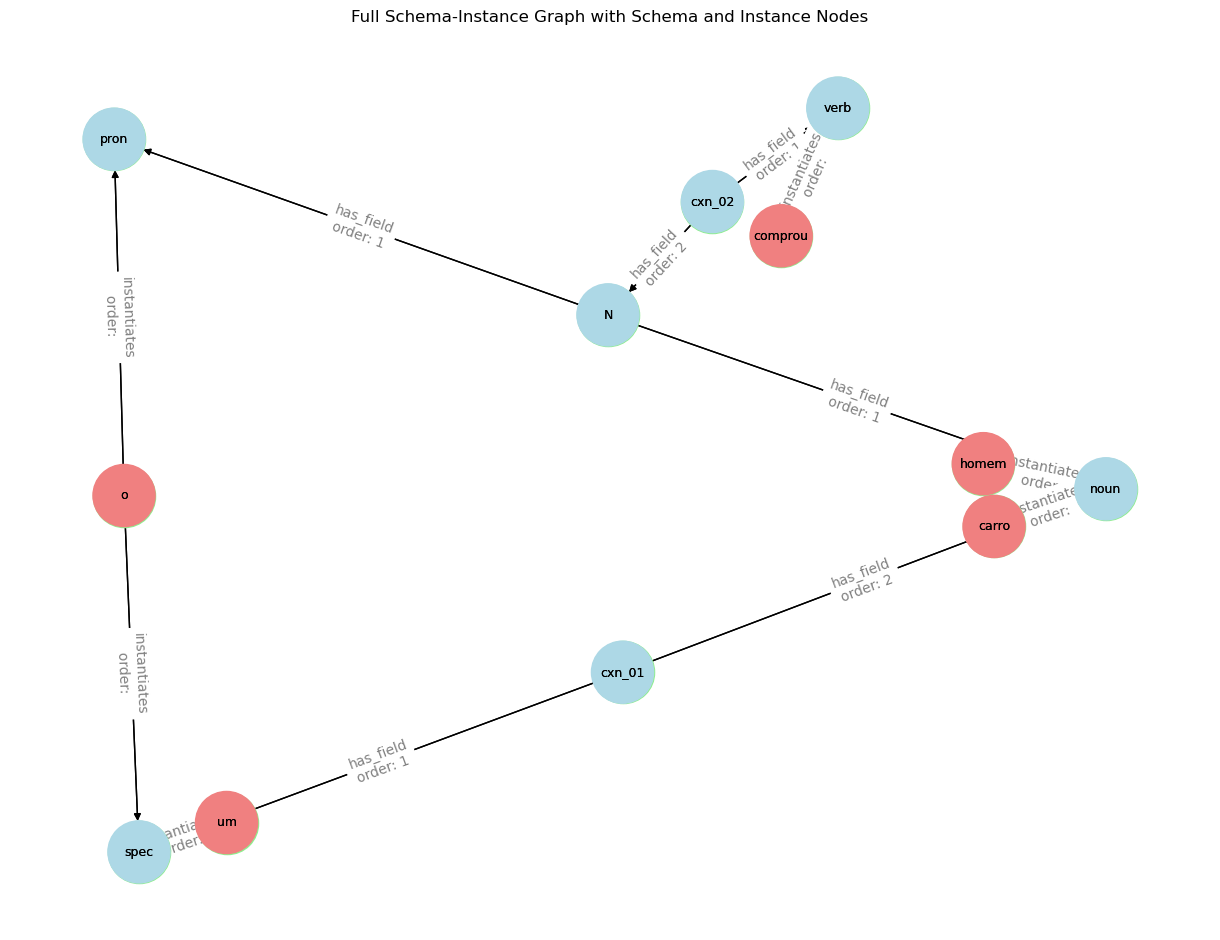

In [1]:
# Simplified Schema Graph: All nodes are Schemas and fields are also Schemas

import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import HeteroData

# Define schema nodes with AND/OR metadata
schema_nodes = [
    {"id": "cxn_01", "type": "Schema","logic": "AND"},
    {"id": "noun", "type": "Schema","logic": "OR"},
    {"id": "spec", "type": "Schema","logic": "OR"},
    {"id": "cxn_02", "type": "Schema","logic": "AND"},
    {"id": "verb", "type": "Schema","logic": "OR"},
    {"id": "pron", "type": "Schema","logic": "OR"},
    {"id": "N", "type": "Schema","logic": "OR"},
]

# Define schema relationships (has_field) with ordering
schema_edges = [
    ("cxn_01", "spec",1),
    ("cxn_01", "noun",2),
    ("cxn_02", "verb",1),
    ("cxn_02", "N",2),
    ("N", "noun",1),
    ("N", "pron",1)
]

# Create heterogeneous graph with only one node type: Schema
from transformers import BertTokenizer, BertModel

# Load BERT model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name)

@torch.no_grad()
def get_bert_embedding(text: str) -> torch.Tensor:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=16)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # CLS token
data = HeteroData()
schema_embeddings = torch.stack([get_bert_embedding(node["id"]) for node in schema_nodes])
data["Schema"].x = schema_embeddings
schema_index = {n["id"]: i for i, n in enumerate(schema_nodes)}

# Create has_field edges between Schema nodes
has_field_src = [schema_index[src] for src, dst, _ in schema_edges]
has_field_dst = [schema_index[dst] for src, dst, _ in schema_edges]
edge_index = torch.tensor([has_field_src, has_field_dst], dtype=torch.long)
data["Schema", "has_field", "Schema"].edge_index = edge_index

data["Schema", "rev_has_field", "Schema"].edge_index = edge_index.flip(0)

# Visualize the graph with NetworkX
G = nx.DiGraph()
for node in schema_nodes:
    G.add_node(node["id"], type="Schema")
for src, dst, order in schema_edges:
    G.add_edge(src, dst, relation="has_field")

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
node_labels = {n: n for n in G.nodes()}
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Unified Schema Graph (Schemas with Schema Fields)")
plt.axis('off')
plt.show()

# Read instances from a CSV file and link to Schema nodes
import pandas as pd

# CSV format: instance_id,schema_id
instances_df = pd.read_csv("instances.csv")

# Add Instance nodes
instance_ids = instances_df["instance_id"].unique().tolist()
instance_embeddings = torch.stack([get_bert_embedding(inst) for inst in instance_ids])
data["Instance"].x = instance_embeddings
instance_index = {id_: i for i, id_ in enumerate(instance_ids)}

# Create instance_to_schema edges
instance_to_schema = [
    (instance_index[row["instance_id"]], schema_index[row["schema_id"]])
    for _, row in instances_df.iterrows()
    if row["schema_id"] in schema_index
]

if instance_to_schema:
    edge_index = torch.tensor(instance_to_schema, dtype=torch.long).t().contiguous()
    data["Instance", "instantiates", "Schema"].edge_index = edge_index
    data["Schema", "rev_instantiates", "Instance"].edge_index = edge_index.flip(0)

# Confirm graph update
print("Schema node count:", len(schema_nodes))
print("Instance node count:", len(instance_ids))
print("Instance -> Schema edges:", data["Instance", "instantiates", "Schema"].edge_index.shape)

# Visualize full schema-instance graph
G_full = nx.DiGraph()

# Add schema nodes
for node in schema_nodes:
    G_full.add_node(node["id"], type="Schema")

# Add instance nodes and their links
for instance_id in instance_ids:
    G_full.add_node(instance_id, type="Instance")

for _, row in instances_df.iterrows():
    inst = row["instance_id"]
    sch = row["schema_id"]
    if sch in schema_index:
        G_full.add_edge(inst, sch, relation="instantiates")

# Add has_field edges with order metadata
for src, dst, order in schema_edges:
    G_full.add_edge(src, dst, relation="has_field", order=order)

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G_full, seed=42)
node_labels = {n: n for n in G_full.nodes()}
edge_labels = {(u, v): f"{d['relation']}\norder: {d.get('order', '')}" for u, v, d in G_full.edges(data=True)}
nx.draw(G_full, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G_full, pos, edge_labels=edge_labels, font_color='gray')
colors = ["lightblue" if G_full.nodes[n]['type'] == "Schema" else "lightcoral" for n in G_full.nodes()]
nx.draw(G_full, pos, with_labels=True, node_color=colors, node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G_full, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Full Schema-Instance Graph with Schema and Instance Nodes")
plt.axis('off')
plt.show()
